## Data - Fetch and Preprocessing

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT/"

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT/dev.txt',
 'pubmed-rct/PubMed_20k_RCT/train.txt',
 'pubmed-rct/PubMed_20k_RCT/test.txt']

## Model_1 - Only Token Embeddings

In [ ]:
def clean_data(data):
  sentences = []
  labels = []
  t_len = 0
  for s in data:
    if s.startswith('O'):
      labels.append(0)
      s = s[10:]
    elif s.startswith('M'):
      labels.append(1)
      s = s[8:]
    elif s.startswith('R'):
      labels.append(2)
      s = s[8:]
    elif s.startswith('C'):
      labels.append(3)
      s = s[11:]
    elif s.startswith('B'):
      labels.append(4)
      s = s[12:]
    else:
      #print(s)
      continue
    s = s.replace('\n', "").replace('\t', " ")
    t_len += len(s.split(' '))
    sentences.append(s)
  if len(sentences) == len(labels):
    return sentences, labels, t_len, len(sentences)

###train_data

In [ ]:
import pandas as pd


In [ ]:
with open(filenames[1], "r") as f:
  train_data = f.readlines()

len(train_data)

210040

In [ ]:
t_sentences, t_labels, t_len, l = clean_data(train_data)
train_clean = pd.DataFrame({'sentences':t_sentences, 'labels':t_labels})
train_clean['labels'].value_counts()

1    59353
2    57953
3    27168
4    21727
0    13839
Name: labels, dtype: int64

###valid data

In [ ]:
with open(filenames[0], "r") as f:
  valid_data = f.readlines()

len(valid_data)

35212

In [ ]:
v_sentences, v_labels, v_len, v_l = clean_data(valid_data)
valid_clean = pd.DataFrame({'sentences':v_sentences, 'labels':v_labels})
valid_clean['labels'].value_counts()

1    9964
2    9841
3    4582
4    3449
0    2376
Name: labels, dtype: int64

### Base Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
t_len/l

26.489335703177073

In [ ]:
tokenizer = layers.TextVectorization(max_tokens = 68000, output_sequence_length=55)

In [ ]:
tokenizer.adapt(t_sentences)

In [ ]:
tokenizer(t_sentences[90])

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([  53,  194,   12,   15, 2040,   56, 1234,  374,   40,  991,    3,
        374,  590, 1270, 3152, 1745, 7173,    3,   57, 1154,    5,    2,
          1,   33,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [ ]:
##Model

inputs = layers.Input(shape=(1, ), dtype='string')
tokens = tokenizer(inputs)
embeddings = layers.Embedding(input_dim=68000, 
                              output_dim=128,
                              input_length=55)(tokens)
x = layers.LSTM(64)(embeddings)
outputs = layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name="base-model")

model.summary()

Model: "base-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,753,733
Trainable params: 8,753,733
Non-trainable params: 0
______________________________________________

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((t_sentences,t_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((v_sentences, v_labels))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(t_labels)

180040

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=int(0.1*len(train_dataset)),
                    epochs=5, validation_data=valid_dataset, validation_steps=int(0.1*len(valid_dataset)),
                    verbose=1)

Epoch 1/5
562/562 [==============================] - 21s 37ms/step - loss: 1.2489 - accuracy: 0.3852 - val_loss: 1.1835 - val_accuracy: 0.4039
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 1.2050 - accuracy: 0.4077 - val_loss: 1.2027 - val_accuracy: 0.3993
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 1.2138 - accuracy: 0.3972 - val_loss: 1.2497 - val_accuracy: 0.3584
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 1.2775 - accuracy: 0.3969 - val_loss: 1.2805 - val_accuracy: 0.4049
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 1.1622 - accuracy: 0.4996 - val_loss: 1.0409 - val_accuracy: 0.6104


## Model_2 - Character Embeddings + Word Embeddings

Using the word embeddings from previous cells.

In [ ]:
def get_chars(s):
  sentences = []
  t_len = 0
  s = " ".join(list(s))
  return s

In [ ]:
t_sentences[0], get_chars(t_sentences[0])

('To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .')

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

t_chars = []
for s in t_sentences:
  t_chars.append(get_chars(s))
l = [len(i) for i in t_chars]
print(np.mean(l))
plt.hist(l)

NameError: ignored

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [ ]:
import tensorflow
from tensorflow.keras import layers

In [ ]:
char_tokernizer = layers.TextVectorization(max_tokens=len(alphabet)+2, 
                                           output_sequence_length = 290)
char_tokernizer.adapt(t_chars)

In [ ]:
t_chars[0], char_tokernizer(t_chars[0])

('T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 <tf.Tensor: shape=(290,), dtype=int64, numpy=
 array([ 3,  7,  4,  6, 21,  2,  9,  3,  4, 18,  5,  3,  2,  3, 13,  2,  2,
        17, 17,  4, 11,  5, 11, 19,  7, 17, 31, 20,  2,  2, 27,  9,  7, 17,
        10,  5,  4, 12, 19, 12,  7, 20, 10,  7,  9,  2,  7,  8,  5, 12, 14,
         8,  2, 10,  6,  4,  9,  7, 12,  7,  6,  2,  4,  6,  4, 15, 14,  8,
         7, 21,  4,  6, 18, 14,  5,  4,  6, 15,  7, 22,  4, 12,  4,  3, 19,
     

## SKIMLIT

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
tokens = tokenizer(inputs)
embeddings = layers.Embedding(input_dim=68000, 
                              output_dim=128,
                              input_length=55)(tokens)
token_outputs = layers.Dense(128, activation="relu")(embeddings)
x = layers.LSTM(64)(token_outputs)
word_model = tf.keras.Model(inputs, x)


char_inputs = layers.Input(shape=(1,), dtype='string')
tokens = char_tokernizer(char_inputs)
embeddings = layers.Embedding(input_dim=68, 
                              output_dim=32,
                              input_length=290)(tokens)
x = layers.Bidirectional(layers.LSTM(64))(embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=x)

op = layers.concatenate([word_model.output, char_model.output])

combined_dense = layers.Dense(256, activation="relu")(op)
drop_out = layers.Dropout(0.5)(combined_dense)
dense_op = layers.Dense(256, activation='relu')(drop_out)
drop_out_2 = layers.Dropout(0.5)(dense_op)
final_op = layers.Dense(5, activation='softmax')(drop_out_2)

final_model = tf.keras.Model(inputs = [word_model.input, char_model.input],
                             outputs = final_op)

final_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['input_16[0][0]']               
 ization)                                                                                         
                                                                                                  
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 55, 128)      8704000     ['text_vectorization[8][0]

In [ ]:
tokens_w_c = tf.data.Dataset.from_tensor_slices((t_sentences, t_chars))
labels = tf.data.Dataset.from_tensor_slices(t_labels)
train_data_final = tf.data.Dataset.zip((tokens_w_c, labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
v_chars = []
for s in v_sentences:
  v_chars.append(get_chars(s))

In [ ]:
v_tokens_w_c = tf.data.Dataset.from_tensor_slices((v_sentences, v_chars))
labels_v = tf.data.Dataset.from_tensor_slices((v_labels))
valid_data_final = tf.data.Dataset.zip((v_tokens_w_c, labels_v)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
final_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
final_history = final_model.fit(
    train_data_final,
    epochs=8,
    validation_data=valid_data_final,
    
)

Epoch 1/8
5627/5627 [==============================] - 201s 34ms/step - loss: 0.6426 - accuracy: 0.7591 - val_loss: 0.4470 - val_accuracy: 0.8480
Epoch 2/8
5627/5627 [==============================] - 154s 27ms/step - loss: 0.3666 - accuracy: 0.8790 - val_loss: 0.4073 - val_accuracy: 0.8680
Epoch 3/8
5627/5627 [==============================] - 154s 27ms/step - loss: 0.2766 - accuracy: 0.9126 - val_loss: 0.4519 - val_accuracy: 0.8632
Epoch 4/8
5627/5627 [==============================] - 154s 27ms/step - loss: 0.2196 - accuracy: 0.9328 - val_loss: 0.4841 - val_accuracy: 0.8616
Epoch 5/8
5627/5627 [==============================] - 154s 27ms/step - loss: 0.1830 - accuracy: 0.9450 - val_loss: 0.5051 - val_accuracy: 0.8651
Epoch 6/8
5627/5627 [==============================] - 154s 27ms/step - loss: 0.1551 - accuracy: 0.9530 - val_loss: 0.5436 - val_accuracy: 0.8624
Epoch 7/8
5627/5627 [==============================] - 155s 27ms/step - loss: 0.1325 - accuracy: 0.9594 - val_loss: 0.5955 -

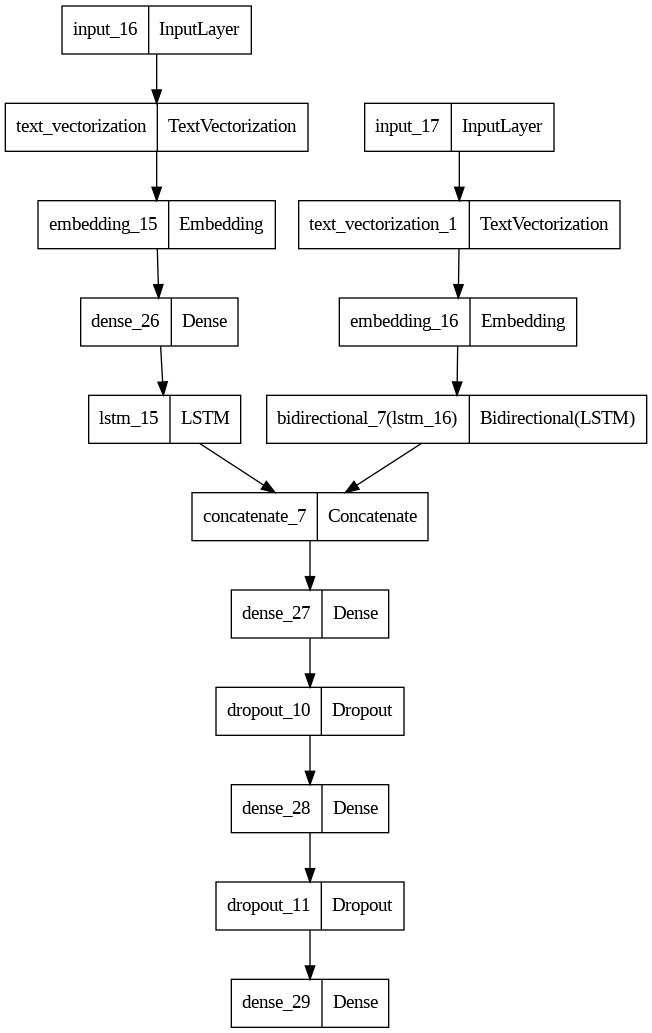

In [ ]:
from keras.utils import plot_model
plot_model(final_model)